In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz 
import pydot

#### Read data and select needed columns

In [2]:
train_data = pd.read_excel('/home/cas/Desktop/TazzFDE/FDE Estimation/Calcul FDE.xlsx', sheet_name='Data all', engine='openpyxl')  
test_data = pd.read_excel('/home/cas/Desktop/TazzFDE/FDE Estimation/Calcul FDE.xlsx', sheet_name='Data cleaner', engine='openpyxl')  


#drop cols after X or lower than FDE
train_data.drop(train_data.iloc[:, 21:25], inplace = True, axis = 1) 
test_data.drop(test_data.iloc[:, 21:25], inplace = True, axis = 1) 


In [3]:
#test_data.isnull().sum() 

In [4]:
#train_data.isnull().sum()

#### Drop the NaN values (were like 1000 so it's fine)

In [5]:
test_data = test_data.dropna()

#### Clean data

In [6]:
test_data['ID Restaurant'] = test_data['ID Restaurant'].replace(["\"3909\""],'3909', regex = True)  
test_data['ID Restaurant'] = test_data['ID Restaurant'].replace(["\\ufeff3909"],'3909', regex = True)  


In [7]:
temp_df =train_data[train_data['actual_delivery_time'].astype(str).str[0:2]!='\\N']

train_data['actual_delivery_time'] = train_data['actual_delivery_time'].replace('\\\\N', temp_df['actual_delivery_time'].mean(), regex=True) 


In [8]:
train_data['Oras'] = train_data['Oras'].apply(lambda x: x.replace('-', ' ')) 
test_data['Oras'] = test_data['Oras'].apply(lambda x: str(x).replace('-', ' ')) 


In [9]:
corrs = train_data.corr()['actual_delivery_time'].abs()
columns = corrs[corrs > .1].index
corrs = corrs.filter(columns)
corrs

distance                  0.130368
actual_delivery_time      1.000000
taken                     0.659169
alocata                   0.667711
ridicata                  0.930212
prep_time                 0.198121
FDE                       0.700561
X Estimat                 0.207392
X Range Low               0.174645
X Range High              0.157067
X or lower than Actual    0.328276
X or lower than FDE       0.123230
Name: actual_delivery_time, dtype: float64

In [10]:
#train_data.info()

In [11]:
#test_data.info()

#### Correct the data types of features

In [12]:
test_data[['taken','alocata','ridicata','prep_time','FDE','actual_delivery_time']] = test_data[['taken','alocata','ridicata','prep_time','FDE','actual_delivery_time']].astype('int64')

In [13]:
train_data[['ID Restaurant','Oras','order id']] = train_data[['ID Restaurant','Oras','order id']].astype('object')
train_data['actual_delivery_time'] = train_data['actual_delivery_time'].astype('int64')

In [14]:
train_data['Oras']=LabelEncoder().fit_transform(train_data['Oras'])
train_data['ID Restaurant']=LabelEncoder().fit_transform(train_data['ID Restaurant']) 
train_data['order id']=LabelEncoder().fit_transform(train_data['order id'])


#### Deal with categorical variables

In [15]:
train_data['day of week'] = train_data['added'].dt.day_name()
train_data.drop('added', axis=1, inplace=True)


In [16]:
train_data = pd.get_dummies(train_data)
train_data.head()

,ID Restaurant,Oras,order id,avg_prep_time,cluster_load,distance,actual_delivery_time,taken,alocata,ridicata,...,X or lower than Actual,X Match FDE,X or lower than FDE,day of week_Friday,day of week_Monday,day of week_Saturday,day of week_Sunday,day of week_Thursday,day of week_Tuesday,day of week_Wednesday
0,403,11,2160,12.29,1.0,3.54,24,1,1,11,...,1,0,0,0,0,0,1,0,0,0
1,1106,3,40135,20.00,1.0,4.05,36,0,0,22,...,1,1,1,0,0,0,1,0,0,0
2,403,11,36882,12.29,1.0,1.60,22,1,1,13,...,1,1,1,0,0,0,1,0,0,0
3,625,3,1329,20.00,1.0,4.49,61,0,0,29,...,0,0,0,0,0,0,1,0,0,0
4,999,3,13449,0.00,1.0,1.02,117,0,23,85,...,0,0,0,0,0,0,1,0,0,0


#### Convert features & labels to arrays

In [17]:
y=np.array(train_data['actual_delivery_time']) 
X=train_data.drop('actual_delivery_time',axis=1) 
feature_names_list=list(X.columns)

X=np.array(X)



#len(feature_names_list)

In [18]:
#sns.heatmap(train_data.isnull(),cmap='viridis')

#### Split train & test data

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Choose a baseline (which is based on FDE) for evaluation of my model 

In [20]:
baseline_preds = X_test[:,feature_names_list.index('FDE')]
baseline_errors = abs(baseline_preds-y_test) 

print('Average baseline error: ', round(np.mean(baseline_errors), 2)) 

Average baseline error:  17.27


#### Build model & predict

In [21]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42) 

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

#### Error of my model is:

In [22]:
predictions = rf.predict(X_test) 

errors = abs(predictions - y_test)
#print(errors)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'minutes.')


Mean Absolute Error: 5.75 minutes.


#### Show accuracy (from diff between errors) in more readable form

In [23]:
# Calculate mean absolute percentage error (MAPE)

mape = 100 * (errors / y_test) 

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Accuracy: 88.47 %.


In [24]:
print('Mean Absolute Error:', sm.mean_absolute_error(y_test, predictions))

print('Mean Squared Error:', sm.mean_squared_error(y_test, predictions))

print('Root Mean Squared Error:', np.sqrt(sm.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 5.7529653541014625
Mean Squared Error: 210.06578296462624
Root Mean Squared Error: 14.49364629638195


#### Visualize a tree from the forest

In [25]:
#make a small tree to be able to visualize 

rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3) 
rf_small.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=10)

In [26]:
#variable and value to split node on
#samples = no of data points in a node 
#mean squared error of nod 
#prediction in minutes for all data points in node


#pull out a single tree 
see_tree = rf_small.estimators_[6] 

#save tree as png img 
export_graphviz(see_tree, out_file='see_tree.dot', feature_names = feature_names_list, 
               rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('see_tree.dot') 

graph.write_png('see_tree.png')

#### we have correlation above, but let's see feature importance 

In [27]:
#for numerical feature 
importances = list(rf.feature_importances_)  


Text(0.5, 1.0, 'Feature Importance')

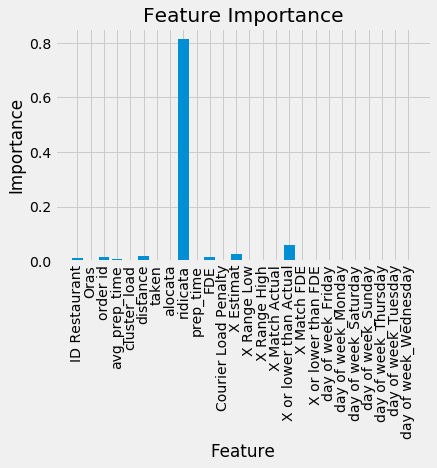

In [28]:
#bar chart to see feature importance
plt.style.use('fivethirtyeight') 

x_values=list(range(len(importances))) 

plt.bar(x_values, importances, orientation='vertical') 

plt.xticks(x_values, feature_names_list, rotation='vertical') 

plt.ylabel('Importance') 
plt.xlabel('Feature') 
plt.title('Feature Importance')

In [29]:
predictions_allData = rf.predict(X)
#data_all=pd.read_excel('/home/cas/Desktop/TazzFDE/FDE Estimation/Calcul FDE.xlsx', sheet_name='Data all', engine='openpyxl')  

#data_all['predicted delivery time'] = predictions_allData 


#### Save predictions in xlsx file

In [30]:
df_predictions = pd.DataFrame(data=predictions_allData, columns=['Predicted Delivery Time'])
writer = pd.ExcelWriter('/home/cas/Desktop/TazzFDE/FDE Estimation/Delivery_Time_Prediction.xlsx', engine='xlsxwriter')
df_predictions.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()